<img src="assets/background_notebook.jpg" />
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2.5vw; color:#c6cde1; font-weight:bold;">
    Introduction to machine learning - Project
    </b>
</p>
<hr style="color:#c6cde1;">
<b>Introduction</b><br><br>
The purpose of this project is to design a model to predict wind power 24h ahead in 10 zones, corresponding to 10 wind farms located in Australia.<br><br>
<b>Authors</b><br><br> 
<i>Camille Bosch, Manon Cornet</i> and <i>Victor Mangeleer</i>

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Initialization
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Initialize all the librairies needed for the project;</li>
        <li style="margin-bottom:10px">Define basic functions.</li>
    </ul> 

In [1]:
# -- LIBRAIRIES --
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler

# Allow notebook to plot in terminal
%matplotlib inline

In [2]:
# -- FUNCTION(S) --
#
# Used to print a basic section title in terminal
def section(title = "UNKNOWN"):

    # Number of letters to determine section size
    title_size = len(title)

    # Section title boundaries
    boundary  = "-"
    for i in range(title_size + 1):
        boundary += "-"
    
    # Printing section
    print(boundary)
    print(f" {title} ")
    print(boundary)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Dataset - Initialization | First look
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Load the orginal datasets (X and y);</li>
        <li style="margin-bottom:10px">Observe the head of the datasets;</li>
        <li style="margin-bottom:10px">Make an histogram of the speeds;</li>
        <li style="margin-bottom:10px">Observe the total speed vs power curve.</li>
    </ul> 

In [3]:
# -- LOADING ORIGINAL DATASETS --
#
# Stores the original dataset
dataset_original_X = []
dataset_original_Y = []

# Load the original dataset
for i in range(1, 11):
    dataset_original_X.append(pd.read_csv(f"data/original/X_Zone_{i}.csv"))
    dataset_original_Y.append(pd.read_csv(f"data/original/Y_Zone_{i}.csv"))

In [4]:
# -- HEAD OF THE DATASETS --
section("WIND TURBINE 1 - X Dataset")
print(dataset_original_X[0].head())
section("WIND TURBINE 1 - Y Dataset")
print(dataset_original_Y[0].head())


----------------------------
 WIND TURBINE 1 - X Dataset 
----------------------------
   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  2.124600 -2.681966  2.864280 -3.666076    1      1  2012     1
1       1  2.521695 -1.796960  3.344859 -2.464761    1      1  2012     2
2       1  2.672210 -0.822516  3.508448 -1.214093    1      1  2012     3
3       1  2.457504 -0.143642  3.215233 -0.355546    1      1  2012     4
4       1  2.245898  0.389576  2.957678  0.332701    1      1  2012     5
----------------------------
 WIND TURBINE 1 - Y Dataset 
----------------------------
   ZONEID  TARGETVAR  Day  Month  Year  Hour
0       1   0.000000    1      1  2012     1
1       1   0.054879    1      1  2012     2
2       1   0.110234    1      1  2012     3
3       1   0.165116    1      1  2012     4
4       1   0.156940    1      1  2012     5


array([[<AxesSubplot: title={'center': 'TARGETVAR'}>]], dtype=object)

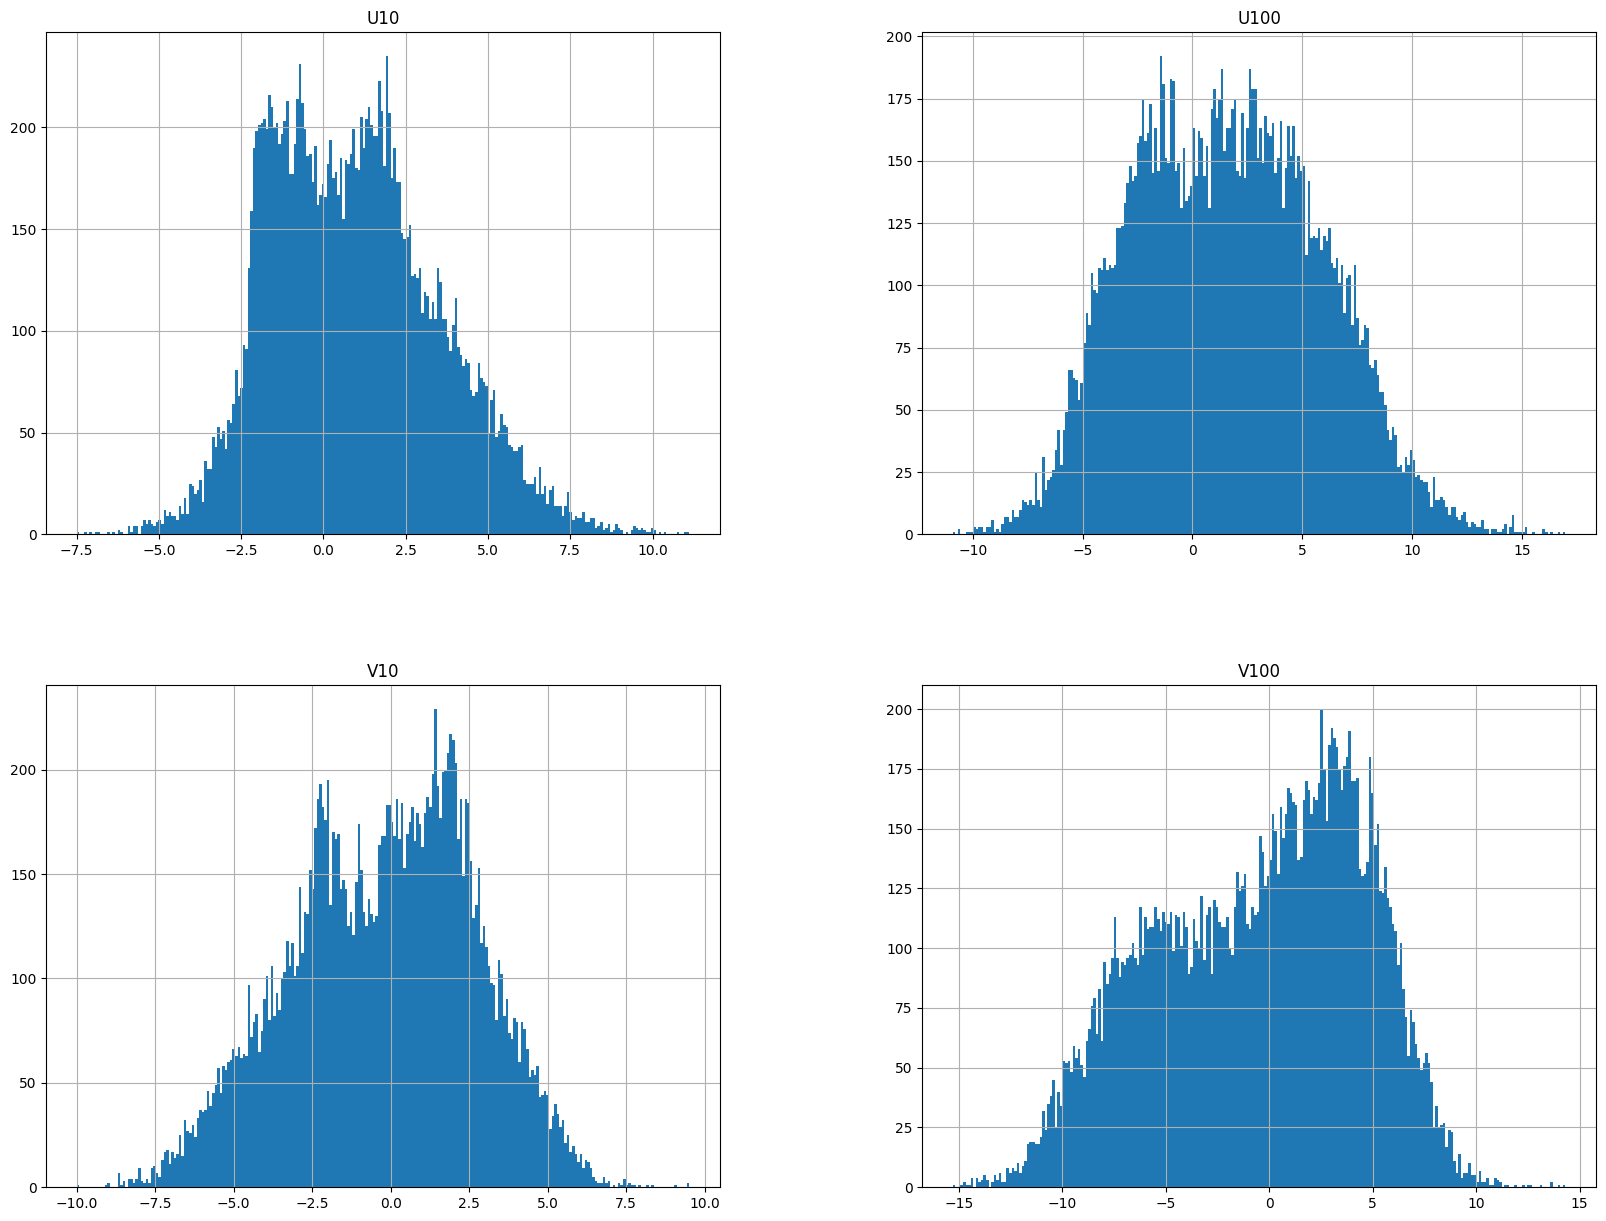

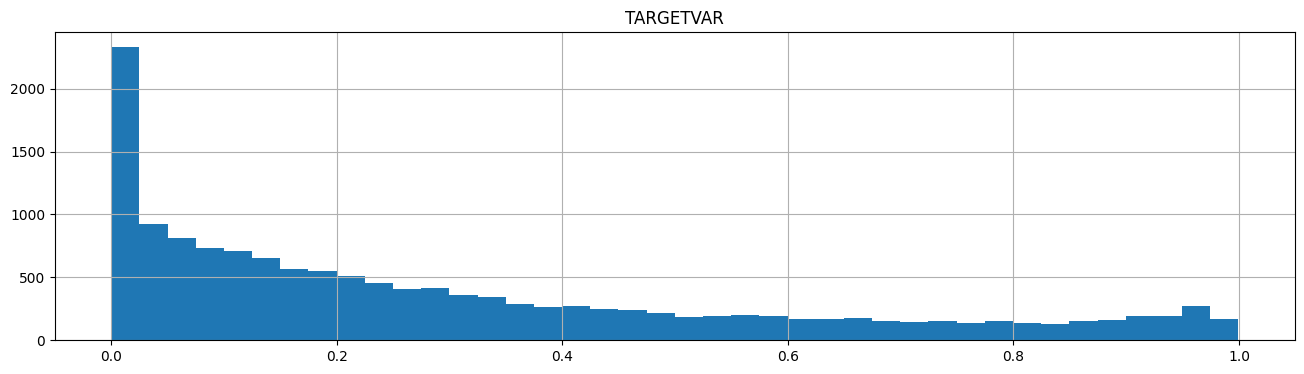

In [5]:
# -- HISTOGRAM OF THE SPEEDS --
#
# Extracting only relevant variables
dataset_X1_relevant = dataset_original_X[0][["U10", "U100", "V10", "V100"]]
dataset_Y1_relevant = dataset_original_Y[0][dataset_original_Y[0]["TARGETVAR"] >= 0]   # /!\ Removing test samples (y = -1) /!\
dataset_Y1_relevant = dataset_Y1_relevant[["TARGETVAR"]]

# Observing distributions
dataset_X1_relevant.hist(bins = 240, figsize = (20, 15))
dataset_Y1_relevant.hist(bins = 40, figsize = (16, 4))

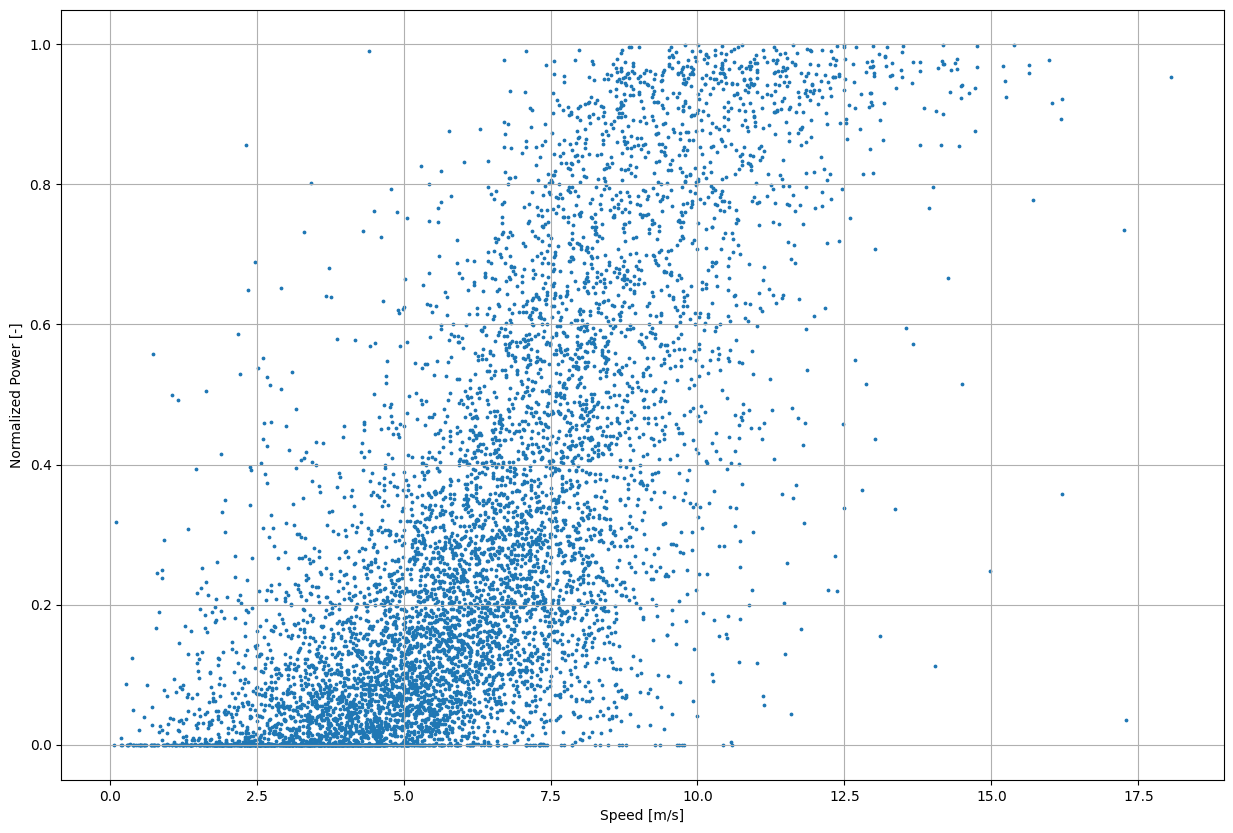

In [6]:
# -- OBSERVING WIND VS POWER --
#
# Removing test data
dataset_X_clean = dataset_original_X[0][dataset_original_Y[0]["TARGETVAR"] >= 0]
dataset_Y_clean = dataset_original_Y[0][dataset_original_Y[0]["TARGETVAR"] >= 0]

# Computing total wind speed
u_wind   = dataset_X_clean[["U100"]].to_numpy()
v_wind   = dataset_X_clean[["V100"]].to_numpy()
wind_tot = np.sqrt(u_wind**2 + v_wind**2)

# Retreiving power
power = dataset_Y_clean[["TARGETVAR"]].to_numpy()

# To see more clearly, one sample out of 2 is removed
for i in range(1):
    wind_tot = wind_tot[1::2]
    power    = power[1::2]

# Plotting
plt.figure(figsize=(15, 10))
plt.scatter(wind_tot, power, s = 3)
plt.grid()
plt.xlabel("Speed [m/s]")
plt.ylabel("Normalized Power [-]")
plt.show()

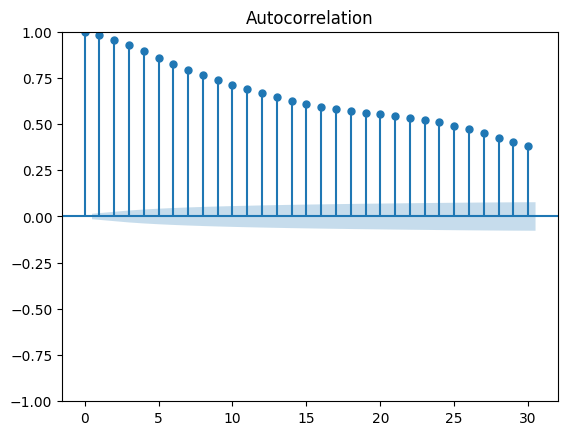

In [7]:
# -- OBSERVING AUTO-CORRELATIONS --
auto_corr_plot = plot_acf(dataset_original_X[0]["U100"], lags=30)

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Dataset - Modifying | DataLoader | Correlation matrix
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Define functions used to modify/improve (hopefully) the datasets;</li>
        <li style="margin-bottom:10px">Define the dataloader, i.e. a custom class used to easily apply modifications to the datasets;</li>
        <li style="margin-bottom:10px">Compute and observe the correlation matrix between all possible modifications.</li>
    </ul> 
</p>



In [8]:
# -- FUNCTIONS --
#
# Used to compute the mean and variance of a variable over some timeslices (number defined by the window size) in the dataset
def computeMeanVariance(datasets, 
                        variables = ["U100", "V100"],
                        window    = 100,
                        variance  = True):

    # Security
    assert window > 1, "Window size must be greater than 1 to compute mean and var"

    # Looping over all the datasets
    for d in datasets:

        # Looping over the variables whose mean and var must be computed
        for v in variables:

            # Retreiving data 
            data = d.loc[: , [v]].to_numpy()

            # Stores mean and variance (1st and 2nd : mean = their value, var = 0 otherwise NAN problem while computation)
            mean = [data[0][0], data[1][0]]
            var  = [0, 0]

            for i in range(2, len(data)):

                # Start and end index for computation
                index_start = i - window if i - window >= 0 else 0
                index_end   = i - 1 if i - 1 >= 0 else 0

                # Computing mean and variance (much faster using numpy variables)
                mean.append(np.mean(data[index_start:index_end]))
                var.append(np.var(data[index_start:index_end]))
            
            # Adding the new data to dataset
            d[f"{v}_mean"] = mean
            if variance:
                d[f"{v}_var"] = var

# Used to compute the instantenous mean and variance of a variable accross multiple datasets
def computeZonalValue(datasets, 
                      variables = ["U100", "V100"],
                      variance  = True):

    # Security
    assert len(datasets) > 1, "To compute mean and var, at least 2 datasets are needed"

    # Looping over the variables whose mean and var must be computed
    for v in variables:

        # Number of samples
        nb_samples = len(datasets[0])

        # Stores all the different values in numpy matrix for efficient computation
        data = np.zeros((nb_samples, len(datasets)))

        # Retreiving all the corresponding data
        for i, d in enumerate(datasets):
            
            # Squeeze is there to remove useless dimension
            data[:, i] = np.squeeze(d.loc[: , [v]].to_numpy())

        # Computing mean and variance (much faster using numpy variables)
        mean = np.mean(data, axis = 1) # Axis = 1 to make mean over each row
        var  = np.var(data, axis = 1)

        # Adding new data to all the datasets
        for d in datasets:
            d[f"{v}_mean"] = mean
            if variance:
                d[f"{v}_var"] = var

# Used to add the value taken by a given variable over the past samples
def addPastTime(datasets,
                variables = ["U100", "V100"],
                window    = 3):

    # Security
    assert window > 0, "Window size must be greater than 0 to add past samples"

    # Looping over the datasets
    for d in datasets:

        # Looping over the different columns
        for i, v in enumerate(variables):

            # Retrieving current data
            data = d[[v]].to_numpy()

            # Stores all the past results
            former_data = np.zeros((len(data), window))

            # Looping over the corresponding data
            for j in range(len(data)):

                # Start and end index for retreiving values
                index_start = j - window if j - window >= 0 else 0
                index_end   = j if j - 1 >= 0 else 0
                
                # Retrieve corresponding value
                values = data[index_start:index_end]

                # Fixing case where looking at starting indexes < window size
                if len(values) != window:
                    values = np.append(np.zeros((window - len(values), 1)), values) # here attention

                # Placing the data (such that by reading left to right: t - 1, t - 2, t - 3, ...)
                for k, val in enumerate(values):
                        former_data[j][k] = val

            # Addding past results in the dataset
            for t in range(window):
                d[f"{v}_(t-{window - t})"] = former_data[:, t]

# Used to remove specific columns from the dataset
def remove(datasets, var_removed):
    for d in datasets:
        for v in var_removed:
            d.drop(v, inplace = True, axis = 1)

# Used to normalize specific columns from the dataset
def normalize(datasets,
              norm_type = "max_abs",
              data_type = "column",
              variables = ["U10", "V10", "U100", "V100"]):

    # Security
    assert norm_type in ["max_abs", "standard", "robust"], "Normalization type = max_abs, standard and robust"
    assert data_type in ["column", "all"],                 "Data type = column, all"

    # Normalization by columns
    if data_type == "column":

        # Looping overall the datasets
        for d in datasets:

            # Current data
            data = d[variables].to_numpy()

            # Normalization
            if norm_type == "max_abs":
                scaled_features = MaxAbsScaler().fit_transform(data)
            elif norm_type == "standard":
                scaled_features = StandardScaler().fit_transform(data)
            elif norm_type == "robust":
                scaled_features = RobustScaler().fit_transform(data)

            # Updating values
            d[variables] = scaled_features

    # Normalization on the whole dataset
    elif data_type == "all":

        # Concatenation of all the dataset for the sake of simplicity
        data = pd.concat(datasets, keys=[i for i in range(len(datasets))])

        # Current data
        data_np = data[variables].to_numpy()

        # Normalization
        if norm_type == "max_abs":
            scaled_features = MaxAbsScaler().fit_transform(data_np)
        elif norm_type == "standard":
            scaled_features = StandardScaler().fit_transform(data_np)
        elif norm_type == "robust":
            scaled_features = RobustScaler().fit_transform(data_np)

        # Updating values
        data[variables] = scaled_features

        # Re-creation of the datasets
        for i in range(len(datasets)):
            datasets[i] = data.loc[i, :]

# Used to retrieve the wind direction and the wind speed from meridional and zonal comp. and add them in the dataset
def wind_comp(datasets, 
              columns      = "both", 
              speed_height = "both"):

    # Security
    assert columns in ["wind_speed", "wind_direction", "both"], "Columns      = wind_speed, wind_direction or both"
    assert speed_height in ["10", "100", "both"],               "Speed height = 10, 100 or both"

    # Find the speed speed and the wind direction
    for d in datasets:

        # Computing speed at 10 meters from th ground
        if speed_height in ["10", "both"]:
            w_u_10 = d["U10"].to_numpy()
            w_v_10 = d["V10"].to_numpy()

            if columns in ["wind_speed", "both"]:
                d["WS10"] = np.sqrt(np.square(w_u_10) + np.square(w_v_10))
            if columns in ["wind_direction", "both"]:
                d["WS10_angle"] = np.arctan2(w_v_10, w_u_10)

        # Computing speed at 100 meters from th ground
        if speed_height in ["100", "both"]:
            w_u_100 = d["U100"].to_numpy()
            w_v_100 = d["V100"].to_numpy()

            if columns in ["wind_speed", "both"]:
                d["WS100"] = np.sqrt(np.square(w_u_100) + np.square(w_v_100))
            if columns in ["wind_direction", "both"]:
                d["WS100_angle"] = np.arctan2(w_v_100, w_u_100)

In [9]:
# -- DATA LOADER -- 
# This class has for purpose to handle the data and make our life easier ! 
#
class dataLoader():
    
    # Initialization of the loader
    def __init__(self, datasets_X, datasets_Y):

        # Stores the original, transformed and final datasets
        self.original_datasets_X    = datasets_X
        self.original_datasets_Y    = datasets_Y
        self.transformed_datasets_X = datasets_X
        self.transformed_datasets_Y = datasets_Y
        self.final_dataset_X        = None
        self.final_dataset_Y        = None

        # Used to know if datasets have been combined or not
        self.isCombined = None

    # Used to display the head of the transformed dataset (first set)
    def showHeadTransformed(self):
        section("Dataset - X - Transformed")
        print(self.transformed_datasets_X[0].head())
        section("Dataset - Y - Transformed")
        print(self.transformed_datasets_Y[0].head())

    # Used to split the final dataset into a train and test set (In test set, values for y are equal to -1)
    def splitTrainTest(self, save = False, save_dir = "new_data"):

        # Security
        assert self.isCombined != None, "You must first use self.finalize"

        # Case 1 - Datasets have been combined all together
        if self.isCombined == True:
            X_train = self.final_dataset_X[self.final_dataset_Y['TARGETVAR'] != -1]
            Y_train = self.final_dataset_Y[self.final_dataset_Y['TARGETVAR'] != -1]
            X_test  = self.final_dataset_X[self.final_dataset_Y['TARGETVAR'] == -1]
            Y_test  = self.final_dataset_Y[self.final_dataset_Y['TARGETVAR'] == -1] # Not useful, I know !

        # Case 2 - Datasets are still separated
        if self.isCombined == False:
            
            X_train, Y_train, X_test, Y_test = list(), list(), list(), list()

            # Looping over all the small datasets
            for x, y in zip(self.final_dataset_X, self.final_dataset_Y):
                X_train.append(x[y['TARGETVAR'] != -1])
                Y_train.append(y[y['TARGETVAR'] != -1])
                X_test.append(x[y['TARGETVAR'] == -1])
                Y_test.append(y[y['TARGETVAR'] == -1])

        # Be careful with the order
        return X_train, X_test, Y_train, Y_test
        
    # Used to perfom final operation on dataset (Combining everything or storing them separately)
    def finalization(self, dataset_type = "combined"):

        # Security
        assert dataset_type in ["combined", "separated"], "The final dataset can either be of type combined or separated"

        # Case 1 - Combining into one big dataset
        if dataset_type == "combined":
            self.final_dataset_X = pd.concat(self.transformed_datasets_X)
            self.final_dataset_Y = pd.concat(self.transformed_datasets_Y)
            self.isCombined = True

        # Case 2 - Separated datasets
        else:
            self.final_dataset_X = self.transformed_datasets_X
            self.final_dataset_Y = self.transformed_datasets_Y
            self.isCombined = False

    #-----------------------------------------------------------------------------------------------------------------------------------
    #                                                               PIPELINE
    #-----------------------------------------------------------------------------------------------------------------------------------
    def pipeline(self, useMeanVariance   = True,  var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,
                       useZonal          = True,  var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                       usePastTime       = True,  var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = 3,
                       useNormalize      = True,  var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "max_abs", data_type = "column",
                       useSpeedNorm      = True,  SpeedNorm_height = "both",
                       useSpeedDirection = True,  SpeedDir_height  = "both",
                       removing          = False, var_removed      = ["U10", "V10", "U100", "V100"]):

        # Copying original dataset
        dX = copy.deepcopy(self.original_datasets_X)
        dY = copy.deepcopy(self.original_datasets_Y)

        # Applying the different transformations
        if useNormalize:
            normalize(dX, variables = var_NORM, norm_type = norm_type, data_type = data_type)
        if useSpeedNorm:
            wind_comp(dX, columns = "wind_speed",     speed_height = SpeedNorm_height)
        if useSpeedDirection:
            wind_comp(dX, columns = "wind_direction", speed_height = SpeedDir_height)
        if useMeanVariance:
            computeMeanVariance(dX, variables = var_MV, window = window_MV, variance = variance_MV)
        if useZonal:
            computeZonalValue(dX, variables = var_ZON, variance = variance_ZON)
        if usePastTime:
            addPastTime(dX, variables = var_PT, window = window_ZON)
        if removing:
            remove(dX, variables = var_removed)
        
        # Updating dataset
        self.transformed_datasets_X = dX
        self.transformed_datasets_Y = dY

        # Making sure one has to finalize again
        self.isCombined = None

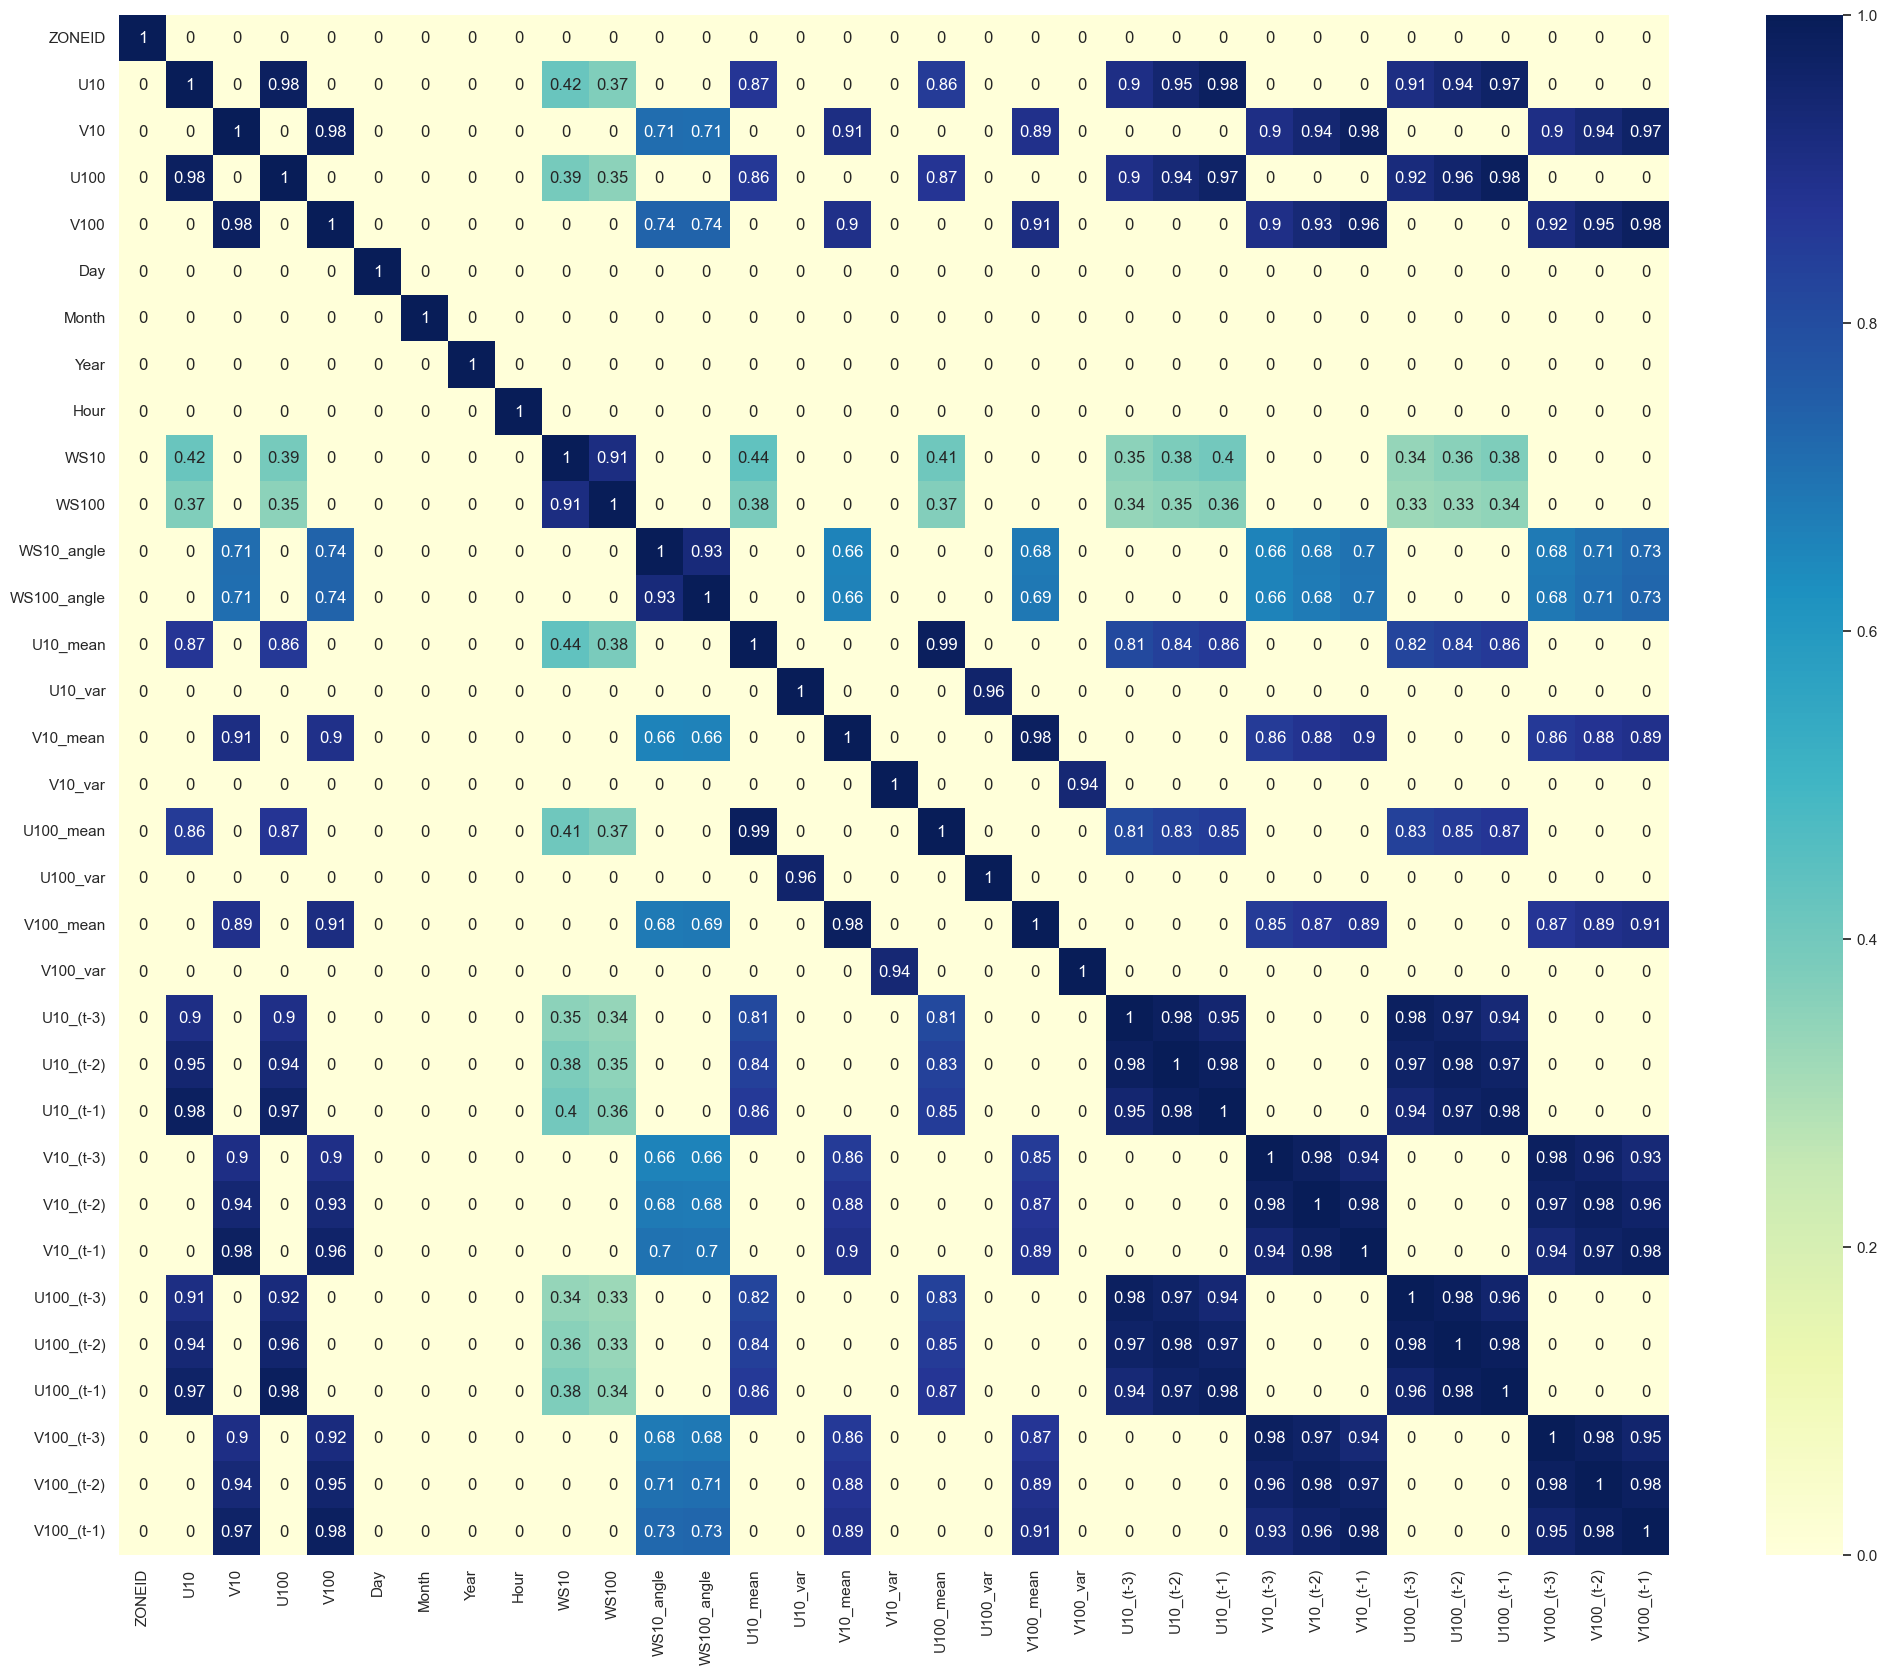

In [10]:
# -- CORRELATION MATRIX -- 
#
# Define which correlation matrix to compute
nb_correlation = 1

# Used to plot correlation matrix
def plotCorrelationMatrix(loader, treshold = 0.3, color = "YlGnBu", number = 1):

    # Finalization of the loader
    loader.finalization(dataset_type = "combined")
    
    # Retreives the train and test set (in Pandas frame)
    data_X, _, _, _ = loader.splitTrainTest()

    # Plotting correlation matrix, removing low values, changing plot color
    corr             = data_X.corr()
    corr[np.abs(corr) < treshold] = 0
    sns.set(rc={'figure.figsize':(25, 20)})
    sns.heatmap(corr, cmap = color, annot = True)
    plt.savefig(f"graphs/correlation/correlation_matrix_{number}.png")

# Initialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Plotting
if nb_correlation == 1:
    loader.pipeline(norm_type = "max_abs", data_type = "all")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 1)
elif nb_correlation == 2:
    loader.pipeline(norm_type = "standard", data_type = "all")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 2)
elif nb_correlation == 3:
    loader.pipeline(norm_type = "robust", data_type = "all")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 3)
elif nb_correlation == 4:
    loader.pipeline(norm_type = "max_abs", data_type = "column")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 4)
elif nb_correlation == 5:
    loader.pipeline(norm_type = "standard", data_type = "column")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 5)
else:
    loader.pipeline(norm_type = "robust", data_type = "column")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 6)

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Dataset - Generation
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to generate and store all the different datasets that will be tested by the different methods.
</p>


In [11]:
# -- CHOICE OF DATASETS --
#
# ---------------
# Wiki - Datasets
# ---------------
# 1) MeanVariance : window = 3, window = 12, window = 24
# 2) ZonalMean    
# 3) PastTime     : window = 1, window = 2,  window = 3
# 4) SpeedNorm    
# 5) SpeedDir     
#
# Define which datasets will be compared to one another
dataset_choice = [1, 2, 3, 4, 5]

# Normalization parameters
norm_parameters = ["robust", "all"]

# Define the different window tested by the MeanVariance
window_MV = [3, 12, 24]

# Define the different window tested by the PastTime
window_PT = [3, 12, 24]

In [12]:
# -- TEMPLATE --
"""
loader.pipeline(useMeanVariance    = True,  var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,
                useZonal           = True,  var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                usePastTime        = True,  var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = 3,
                useNormalize       = True,  var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "max_abs", data_type = "column",
                useSpeedNorm       = True,  SpeedNorm_height = "both",
                useSpeedDirection  = True,  SpeedDir_height  = "both",
                removing           = False, var_removed      = ["U10", "V10", "U100", "V100"])
"""

'\nloader.pipeline(useMeanVariance    = True,  var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,\n                useZonal           = True,  var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,\n                usePastTime        = True,  var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = 3,\n                useNormalize       = True,  var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "max_abs", data_type = "column",\n                useSpeedNorm       = True,  SpeedNorm_height = "both",\n                useSpeedDirection  = True,  SpeedDir_height  = "both",\n                removing           = False, var_removed      = ["U10", "V10", "U100", "V100"])\n'

In [13]:
# -- GENERATION OF THE DATASETS
#
# Stores all the newly generated datasets
datasets_X, datasets_X_submit, datasets_Y, datasets_Y_submit = list(), list(), list(), list()

# Intialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Displaying information over terminal (1)
print("Generating : ...")

# 0 - Originals
loader.pipeline(useMeanVariance    = False,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = False,
                useSpeedNorm       = False,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X.append(X), datasets_X_submit.append(submit_X), 
datasets_Y.append(Y), datasets_Y_submit.append(submit_Y)


# 1 - MeanVariance
if 1 in dataset_choice:
    for w in window_MV:
        loader.pipeline(useMeanVariance    = True,  var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = w,
                        useZonal           = False,
                        usePastTime        = False,
                        useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                        useSpeedNorm       = False,
                        useSpeedDirection  = False,
                        removing           = False)
        loader.finalization()
        X, submit_X, Y, submit_Y = loader.splitTrainTest()
        datasets_X.append(X), datasets_X_submit.append(submit_X), 
        datasets_Y.append(Y), datasets_Y_submit.append(submit_Y)

# 2 - ZonalMean
if 2 in dataset_choice:
    loader.pipeline(useMeanVariance    = False,
                    useZonal           = True, var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                    usePastTime        = False,
                    useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                    useSpeedNorm       = False,
                    useSpeedDirection  = False,
                    removing           = False)
    loader.finalization()
    X, submit_X, Y, submit_Y = loader.splitTrainTest()
    datasets_X.append(X), datasets_X_submit.append(submit_X), 
    datasets_Y.append(Y), datasets_Y_submit.append(submit_Y)

# 3 - PastTime
if 3 in dataset_choice:
    for w in window_PT:
        loader.pipeline(useMeanVariance    = False,
                        useZonal           = False,
                        usePastTime        = True, var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = w,
                        useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                        useSpeedNorm       = False,
                        useSpeedDirection  = False,
                        removing           = False)
        loader.finalization()
        X, submit_X, Y, submit_Y = loader.splitTrainTest()
        datasets_X.append(X), datasets_X_submit.append(submit_X), 
        datasets_Y.append(Y), datasets_Y_submit.append(submit_Y)

# 4 - SpeedNorm
if 4 in dataset_choice:
    loader.pipeline(useMeanVariance    = False,
                    useZonal           = False,
                    usePastTime        = False,
                    useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                    useSpeedNorm       = True, SpeedNorm_height = "both",
                    useSpeedDirection  = False,
                    removing           = False)
    loader.finalization()
    X, submit_X, Y, submit_Y = loader.splitTrainTest()
    datasets_X.append(X), datasets_X_submit.append(submit_X), 
    datasets_Y.append(Y), datasets_Y_submit.append(submit_Y)

# 5 - SpeedDir
if 5 in dataset_choice:
    loader.pipeline(useMeanVariance    = False,
                    useZonal           = False,
                    usePastTime        = False,
                    useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                    useSpeedNorm       = False,
                    useSpeedDirection  = True, SpeedDir_height  = "both",
                    removing           = False)
    loader.finalization()
    X, submit_X, Y, submit_Y = loader.splitTrainTest()
    datasets_X.append(X), datasets_X_submit.append(submit_X), 
    datasets_Y.append(Y), datasets_Y_submit.append(submit_Y)

# Displaying information over terminal (2)
print("Generating : Done")

Generating : ...
Generating : Done


[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Model - Pre-Classifier
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Trained a model to pre-classify the data (wether or not, power is created with wind conditions);</li>
        <li style="margin-bottom:10px">Observe a custom class "ModelEnsemble" which allow to create a model resulting from the combination of the pre-classifier and a trained model.</li>
    </ul> 
</p>

In [14]:
# -- ENSEMBLE MODEL --
#
# The goal of this class is to create our own predict function which is composed of 2 main steps:
# - The pre-classifier's determines whether or not the wind is sufficiently high to have a power creation
# - The model which predicts the power creation
class ModelEnsemble():

    # Initialization of the ensemble model
    def __init__(self, model_prec_classifier, model_trained):
        self.pre_classifier = model_prec_classifier
        self.trained        = model_trained 
    
    # Used to compute predictions
    def predict(self, x, predict_treshold = 0.95):

        # 1 - Determining if there is power or not 
        PC_results  = self.pre_classifier.predict_proba(x)

        # 2 - Power predictions
        MOD_results = self.trained.predict(x)

        # 3 - Replacing predictions with pre-classifier results 
        for i, r in enumerate(PC_results):
            MOD_results[i] = 0 if r[0] > predict_treshold else MOD_results[i]

        return MOD_results


In [15]:
# -- PRE-CLASSIFIER'S DATASET --
# 
# Creation of the special dataset for training the pre-classifier
dataset_X_preclassifier = copy.deepcopy(datasets_X[0])
dataset_Y_preclassifier = copy.deepcopy(datasets_Y[0])

# Transforming into binary classification problem (0 = no power, 1 = power to predict)
dataset_Y_preclassifier[dataset_Y_preclassifier["TARGETVAR"] != 0] = 1
dataset_X_preclassifier                                            = dataset_X_preclassifier.to_numpy()
dataset_Y_preclassifier                                            = dataset_Y_preclassifier["TARGETVAR"].to_numpy()

# Retreiving train and test sets
X_PRE_train, X_PRE_test, y_PRE_train, y_PRE_test = train_test_split(dataset_X_preclassifier, dataset_Y_preclassifier, test_size = 0.3, random_state = 69)

In [16]:
# -- TRAINING AND TESTING OF THE PRE-CLASSIFIER -- 
#
# Definition of the parameters that will be tested
GS_param_dt  = {'max_depth'   : [i for i in range(7, 13)]}

# Initialization of the model
model_pre_classifier = GridSearchCV(tree.DecisionTreeClassifier(), GS_param_dt)

# Finding the best parameter
model_pre_classifier.fit(X_PRE_train, y_PRE_train)

# Computing final accuracy 
accuracy_pre_classifier = model_pre_classifier.score(X_PRE_test, y_PRE_test)

# Display information over terminal (1)
section("Results")
print(f"Pre classifier's accuracy [%] : {accuracy_pre_classifier * 100}")
print(model_pre_classifier.best_params_)

---------
 Results 
---------
Pre classifier's accuracy [%] : 92.51129177958445
{'max_depth': 11}


[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Model - Training | Testing | Plotting results
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Find functions to plot easily compare accuracy results of a method against each dataset.</li>
    </ul> 
</p>

In [71]:
# -- FUNCTIONS --
#
# Used to compute a model's accuracy against different datasets

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, median_absolute_error

def modelTesting(datasets_X, 
                 datasets_y, 
                 model, 
                 test_size = 0.3, 
                 random_state = 69):
    
    # Contains mean accuracy of the model against each dataset
    accuracy_train = []
    accuracy_test = []
    y_true = []
    y_pred = []

    # Looping over whole the different datasets
    for X, y in zip(datasets_X, datasets_y):
        
        # Final conversion (Numpy and retrieving targets)
        X = X.to_numpy()
        y = y[["TARGETVAR"]].to_numpy().ravel()


        # Retrieving datasets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

        # Fitting the model on current split
        model.fit(X_train, y_train)

        # Prediction 
        y_pred.append(model.predict(X_test))
        y_true.append(y_test)
        

        # Accuracy
        accuracy_train.append(model.score(X_train, y_train))
        accuracy_test.append(model.score(X_test, y_test))

    return accuracy_train, accuracy_test, y_pred, y_true 


def computeKBest (parameters, 
                  acc_train, 
                  acc_test, 
                  y_pred, 
                  y_true):

    # 2 - Compute the best error 
    acc_test_best, acc_train_best = [], []
    y_pred_best,  y_true_best     = [], []
    k_best                        = []

    # Looping over accuracies to find best results
    for a1, a2, y1, y2 in zip(acc_train, acc_test, y_pred, y_true):

        # Finding best test accuracy
        max_value = max(a2)
        max_index = a2.index(max_value)

        # Adding results
        acc_test_best.append(max_value)
        acc_train_best.append(a1[max_index])

        y_pred_best.append(y1[max_index])
        y_true_best.append(y2[max_index])

        k_best.append(parameters[max_index])

    return acc_test_best, acc_train_best, y_pred_best, y_true_best, k_best

def computeError(n_y_true, 
                 n_y_pred):
    """Compute the error to evaluate the performance of the model 

    Parameters
    -----------
    n_y_true: list of np.array
              Ground truth (correct) target values.


    n_y_pred: list of np.array 
              Estimated target values.
    
   
    """
    mae, rmse, mdae = [], [], []
    r2, auc = [], []
    for y_true, y_pred in zip(n_y_true, n_y_pred):
        mae.append(mean_absolute_error(y_true, y_pred))
        rmse.append(mean_squared_error(y_true, y_pred, squared = False))
        mdae.append(median_absolute_error(y_true, y_pred))

        r2.append(r2_score(y_true, y_pred, force_finite = True))
        auc.append(regression_roc_auc_score(y_true, y_pred, num_rounds = 1000))

    return mae, rmse, mdae, r2, auc


def regression_roc_auc_score(y_true, y_pred, num_rounds = 10000):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred: array-like of shape (n_samples,). Target scores.
  num_rounds: int or string. If integer, number of random pairs of observations. 
              If string, 'exact', all possible pairs of observations will be evaluated.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  num_pairs = 0
  num_same_sign = 0
  
  for i, j in _yield_pairs(y_true, num_rounds):
    diff_true = y_true[i] - y_true[j]
    diff_score = y_pred[i] - y_pred[j]
    if diff_true * diff_score > 0:
      num_same_sign += 1
    elif diff_score == 0:
      num_same_sign += .5
    num_pairs += 1
      
  return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
  """
  Returns pairs of valid indices. Indices must belong to observations having different values.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  num_rounds: int or string. If integer, number of random pairs of observations to return. 
              If string, 'exact', all possible pairs of observations will be returned.
  
  Yields:
  -------
  i, j: tuple of int of shape (2,). Indices referred to a pair of samples.
  
  """

  if num_rounds == 'exact':
    for i in range(len(y_true)):
      for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
        yield i, j     
  else:
    for r in range(num_rounds):
      i = np.random.choice(range(len(y_true)))
      j = np.random.choice(np.where(y_true != y_true[i])[0])
      yield i, j
  
# Used to compare the accuracy of a model against each dataset
def modelPlotResults(parameters, 
                     acc_train, 
                     acc_test,
                     y_pred, 
                     y_true, 
                     xlabel     = "UNKNOWN", 
                     param_name = "UNKNOWN", 
                     fontsize = 15, 
                     save_path = "graphs/"):

    # 1 - Evolution of the test accuracy
    plt.figure(figsize = (20, 10))
    sns.set(font_scale = 1)

    # Plotting evolution curve for a specific dataset with varying parameter value
    for i, a in enumerate(acc_test):
        plt.plot(parameters, [a_i * 100 for a_i in a], label = f"Dataset n°{i}", linewidth = 4)
    
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.ylabel("Accuracy [%]", fontsize = fontsize)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.savefig(f"{save_path}_1.png")
    plt.show()

   
    acc_test_best, acc_train_best, y_pred_best, y_true_best, k_best = computeKBest(parameters, 
                                                                                    acc_train, 
                                                                                    acc_test, 
                                                                                    y_pred, 
                                                                                    y_true)

                                                                     
    # 2 - Bar plot of accuracy 
    # Contains x-axis labels
    x_ax_labels = [f"D{i} - {param_name} = {k_best[i]}" for i in range(len(acc_train))]

    # Used to make x-axis    
    index = [i for i in range(len(acc_train))]

    # Plotting the results
    plt.figure(figsize = (20, 7))
    plt.bar([i - 0.2 for i in index], [a_i * 100 for a_i in acc_train_best], 0.4, label = "Train")
    plt.bar([i + 0.2 for i in index], [a_i * 100 for a_i in acc_test_best], 0.4, label = "Test")
    
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.xticks(index, x_ax_labels)
    plt.ylabel("Accuracy [%]", fontsize = fontsize)
    plt.savefig(f"{save_path}_2.png")
    plt.show()
    
    
    # 3 - Bar plot for different error 
    mae, rmse, mdae = [], [], []
    r2, auc = [], []
    mae, rmse, mdae, r2, auc = computeError(y_pred_best, y_true_best)

    # Contains x-axis labels
    x_ax_labels = [f"Dataset n°{i}-{param_name} = {k_best[i]}" for i in range (len(y_pred))]

    # Used to make x-axis
    index = [i for i in range(len(y_pred))]
    
    # Plotting the results
    plt.figure()
    plt.subplot(211)
    plt.bar([i - 0.2 for i in index], [mae_i *100 for mae_i in mae], 0.2, label = "Mean Absolute Error")
    plt.bar([i   for i in index], [rmse_i *100  for rmse_i in rmse], 0.2, label = "Root Mean Squared Error")
    plt.bar([i + 0.2 for i in index], [mdae_i  *100 for mdae_i in mdae], 0.2, label = "Median Absolute Error")
    plt.ylabel("Error [%] ", fontsize = fontsize)
    plt.xticks(index, x_ax_labels)
    plt.legend(loc="upper left", fontsize = fontsize)
    

    plt.subplot(212)
    plt.bar([i - 0.1 for i in index], [r2_i for r2_i in r2], 0.2, label = "R2 Score")
    plt.bar([i + 0.1 for i in index], [auc_i  for auc_i in auc], 0.2, label = "AUC")
    plt.ylabel("Error ", fontsize = fontsize)
    plt.xticks(index, x_ax_labels)
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.savefig(f"{save_path}_Error.png")
    plt.show()






[comment]: <> (Section)
<hr style="color:#c6cde1; width: 160px;" align="left">
<p style="color:#c6cde1;">Decision tree (Example)</p>
<hr style="color:#c6cde1; width: 160px;" align="left">

In [39]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
dt_param = np.linspace(8, 14, 6, dtype = int)

# Stores the accuracy of the training and testing
dt_accuracy_train = [[] for i in range(len(datasets_X))]
dt_accuracy_test  = [[] for i in range(len(datasets_X))]
dt_y_pred = [[] for i in range(len(datasets_X))]
dt_y_true = [[] for i in range(len(datasets_X))]


for depth in dt_param:

    # Initialization of the model
    model = tree.DecisionTreeRegressor(max_depth = depth)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        dt_accuracy_train[i].append(acc_1)
        dt_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        dt_y_pred[i].append(y_pred)
        dt_y_true[i].append(y_true)
    

147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600
147600


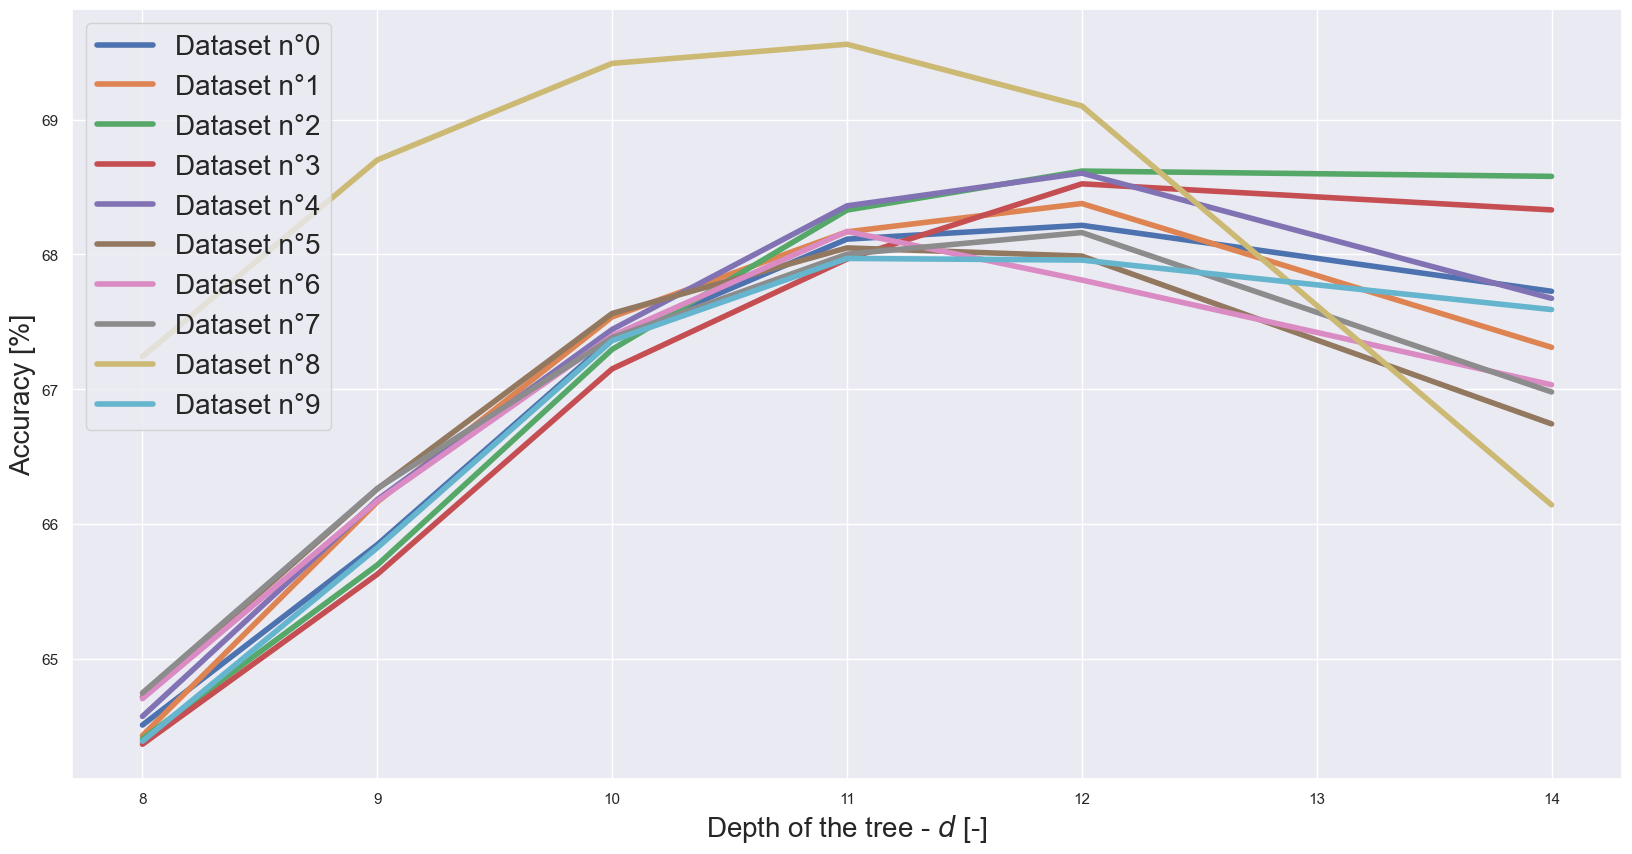

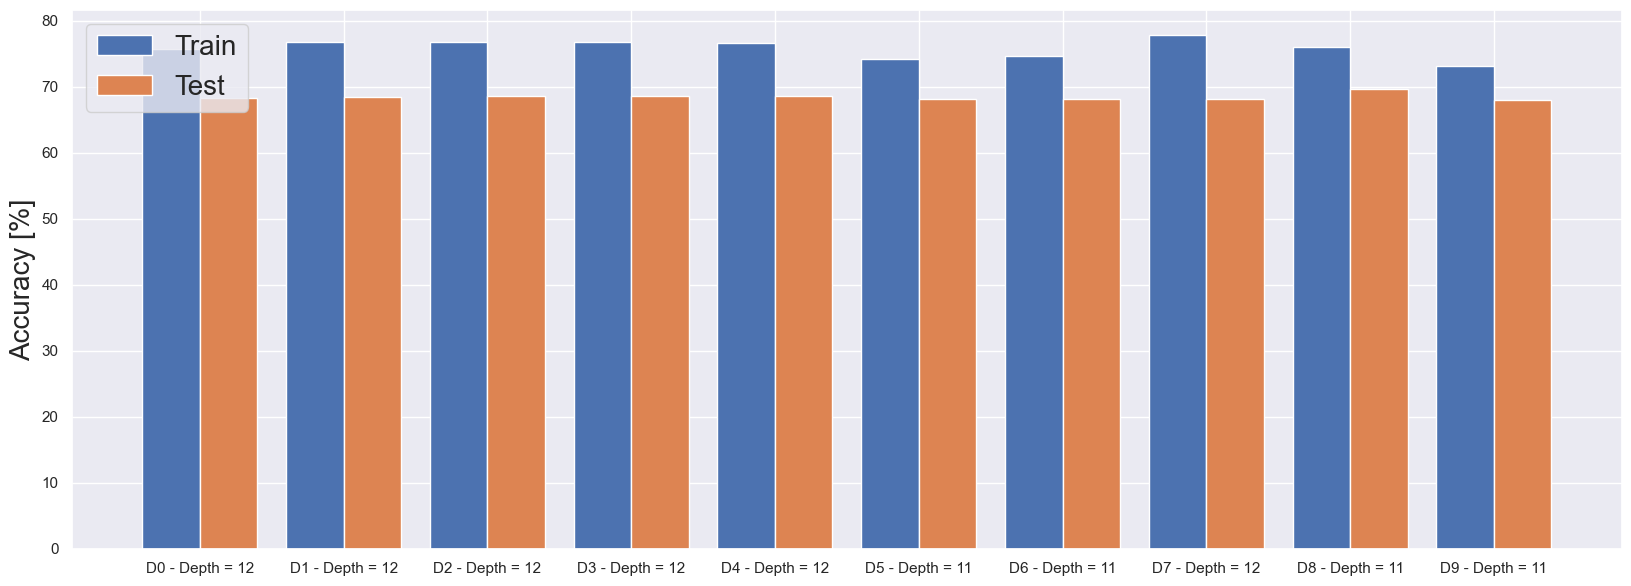

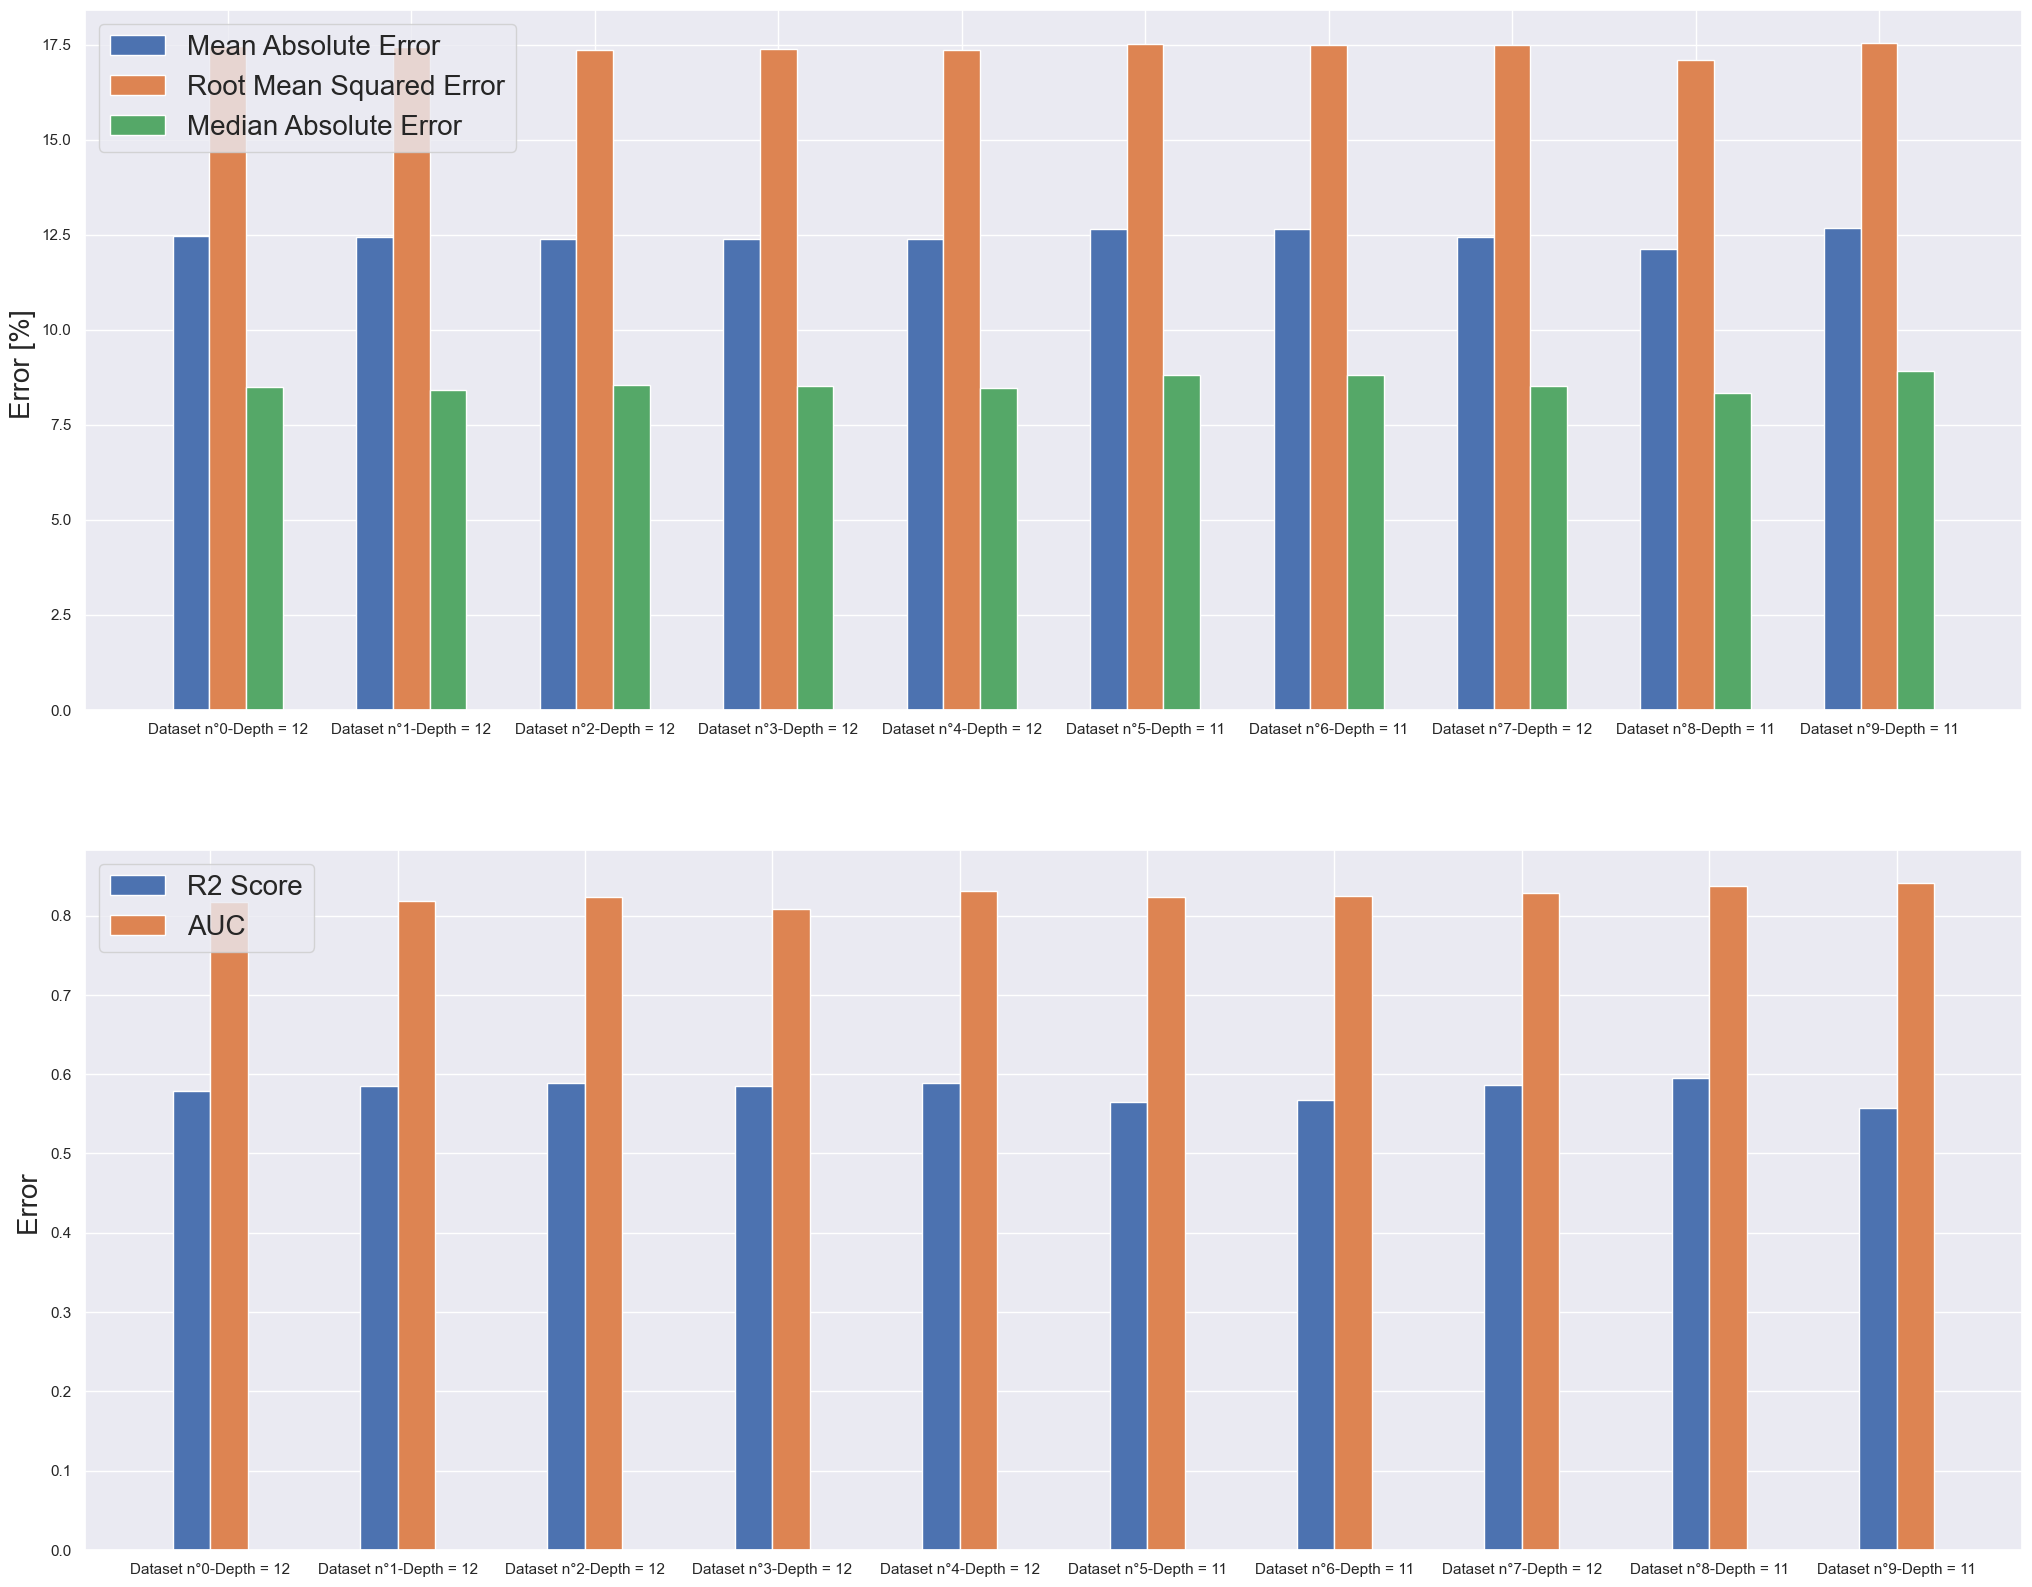

In [72]:
# -- PLOTTING THE RESULTS --
modelPlotResults(dt_param, dt_accuracy_train, dt_accuracy_test, dt_y_pred, dt_y_true,
                 xlabel = "Depth of the tree - $d$ [-]", fontsize = 20, 
                 param_name = "Depth", save_path = "graphs/dt/dt")

<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Camille
    </b>
</p>

NOT FINISH

<hr style="color:#c6cde1; width: 145px;" align="left">
<p style="color:#c6cde1;">KNeighborsRegressor</p>
<hr style="color:#c6cde1; width: 145px;" align="left">


In [20]:
# -- Generating results KNN -- 


from sklearn.neighbors import KNeighborsRegressor

# Definition of the parameters to be tested
k_param = np.arange(1, 100, 10, dtype = int)

# Stores the accuracy of the training and testing
knn_accuracy_train = [[] for i in range(len(datasets_X))]
knn_accuracy_test  = [[] for i in range(len(datasets_X))]
knn_y_pred = [[] for i in range(len(datasets_X))]
knn_y_true = [[] for i in range(len(datasets_X))]

for k in k_param:

    # Initialization of the model
    model = KNeighborsRegressor(n_neighbors = k)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        knn_accuracy_train[i].append(acc_1)
        knn_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        knn_y_pred[i].append(y_pred)
        knn_y_true[i].append(y_true)


KeyboardInterrupt: 

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(dt_param, dt_accuracy_train, dt_accuracy_test, dt_y_pred, dt_y_true,
                 xlabel = "Number of k Neighbors - $k$ [-]", fontsize = 10, 
                 param_name = "kNeighbors", save_path = "graphs/knn/knn")

<hr style="color:#c6cde1; width: 102px;" align="left">
<p style="color:#c6cde1;">Random Forest</p>
<hr style="color:#c6cde1; width: 102px;" align="left">

In [42]:
# -- Generating results Random Forest -- 
# Definition of the parameters to be tested
max_depth = np.linspace(8, 14, 6, dtype = int)
print(max_depth)

# Stores the accuracy of the training and testing
dt_accuracy_train = [[] for i in range(len(datasets_X))]
dt_accuracy_test  = [[] for i in range(len(datasets_X))]
dt_y_pred = [[] for i in range(len(datasets_X))]
dt_y_true = [[] for i in range(len(datasets_X))]

for depth in max_depth:

    # Initialization of the model
    model = ensemble.RandomForestRegressor(max_depth = depth, n_estimators = 20)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        dt_accuracy_train[i].append(acc_1)
        dt_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        dt_y_pred[i].append(y_pred)
        dt_y_true[i].append(y_true)

[ 8  9 10 11 12 14]


KeyboardInterrupt: 

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(dt_param, dt_accuracy_train, dt_accuracy_test, dt_y_pred, dt_y_true,
                 xlabel = "Depth of the tree - $d$ [-]", fontsize = 10, 
                 param_name = "Depth", save_path = "graphs/rf/rf")

<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Manon
    </b>
</p>

<hr style="color:#c6cde1; width: 160px;" align="left">
<p style="color:#c6cde1;">Support Vector Machine</p>
<hr style="color:#c6cde1; width: 160px;" align="left">

<hr style="color:#c6cde1; width: 75px;" align="left">
<p style="color:#c6cde1;">Regression</p>
<hr style="color:#c6cde1; width: 75px;" align="left">

<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Victor
    </b>
</p>

<hr style="color:#c6cde1; width: 115px;" align="left">
<p style="color:#c6cde1;">Ridge Regression</p>
<hr style="color:#c6cde1; width: 115px;" align="left">

In [33]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
alpha_param = np.linspace(40, 0.01, 50)

# Stores the accuracy of the training and testing
rr_accuracy_train = [[] for i in range(len(datasets_X))]
rr_accuracy_test  = [[] for i in range(len(datasets_X))]

for alpha in alpha_param:

    # Initialization of the model
    model = Ridge(alpha = alpha)

    # Computing accuracies on all the datasets
    acc_train, acc_test = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        rr_accuracy_train[i].append(acc_1)
        rr_accuracy_test[i].append(acc_2)

# Rounding values of alpha for better display
alpha_param = [round(item, 2) for item in alpha_param]

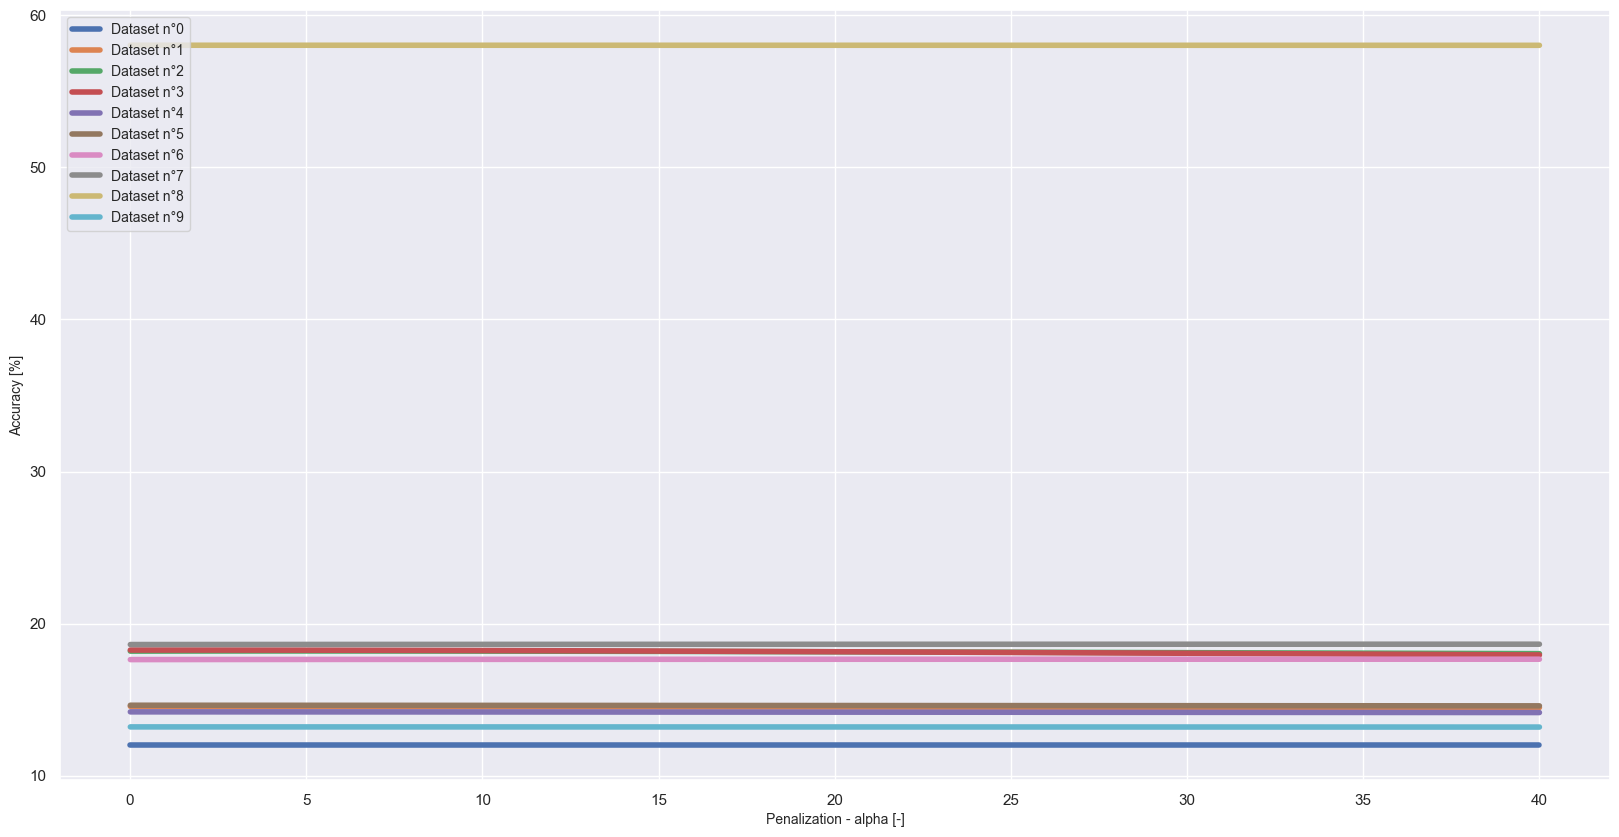

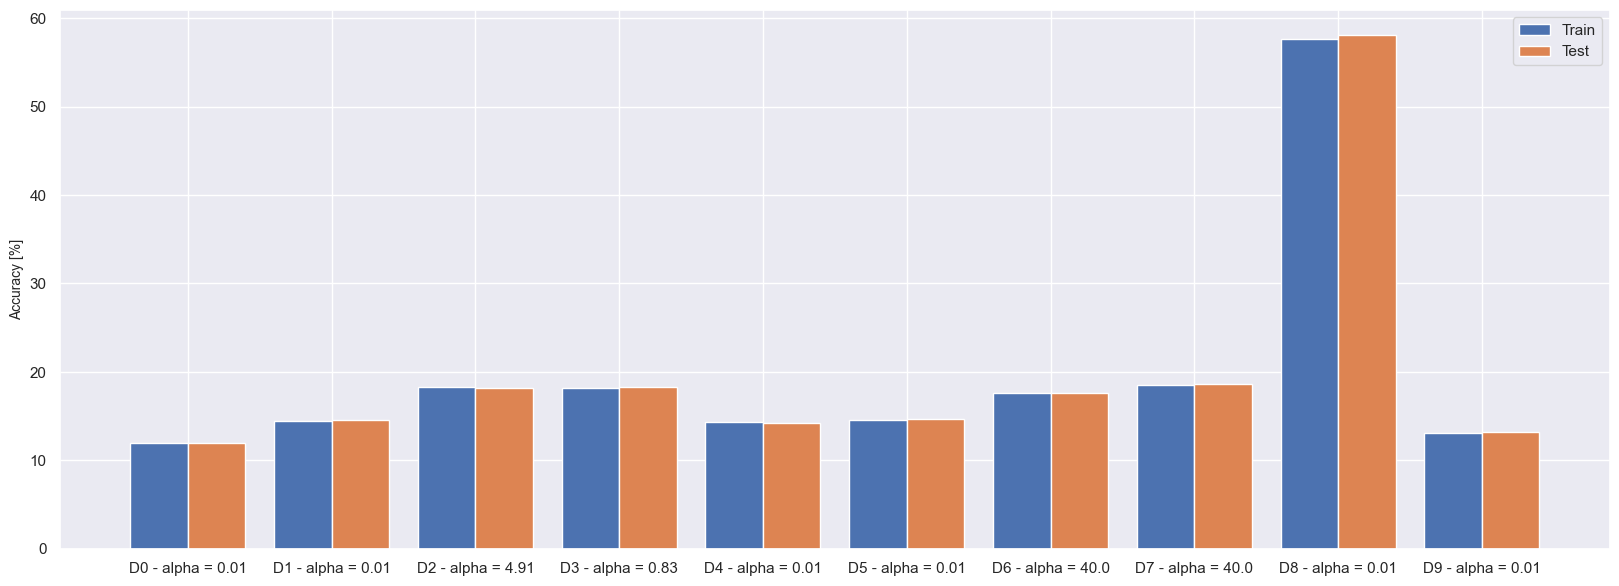

In [34]:
# -- PLOTTING THE RESULTS --
modelPlotResults(alpha_param, rr_accuracy_train, rr_accuracy_test, 
                 xlabel = "Penalization - alpha [-]", fontsize = 10, 
                 param_name = "alpha", save_path = "graphs/rr/rr")

<hr style="color:#c6cde1; width: 155px;" align="left">
<p style="color:#c6cde1;">Multi-Layer-Perceptron</p>
<hr style="color:#c6cde1; width: 155px;" align="left">

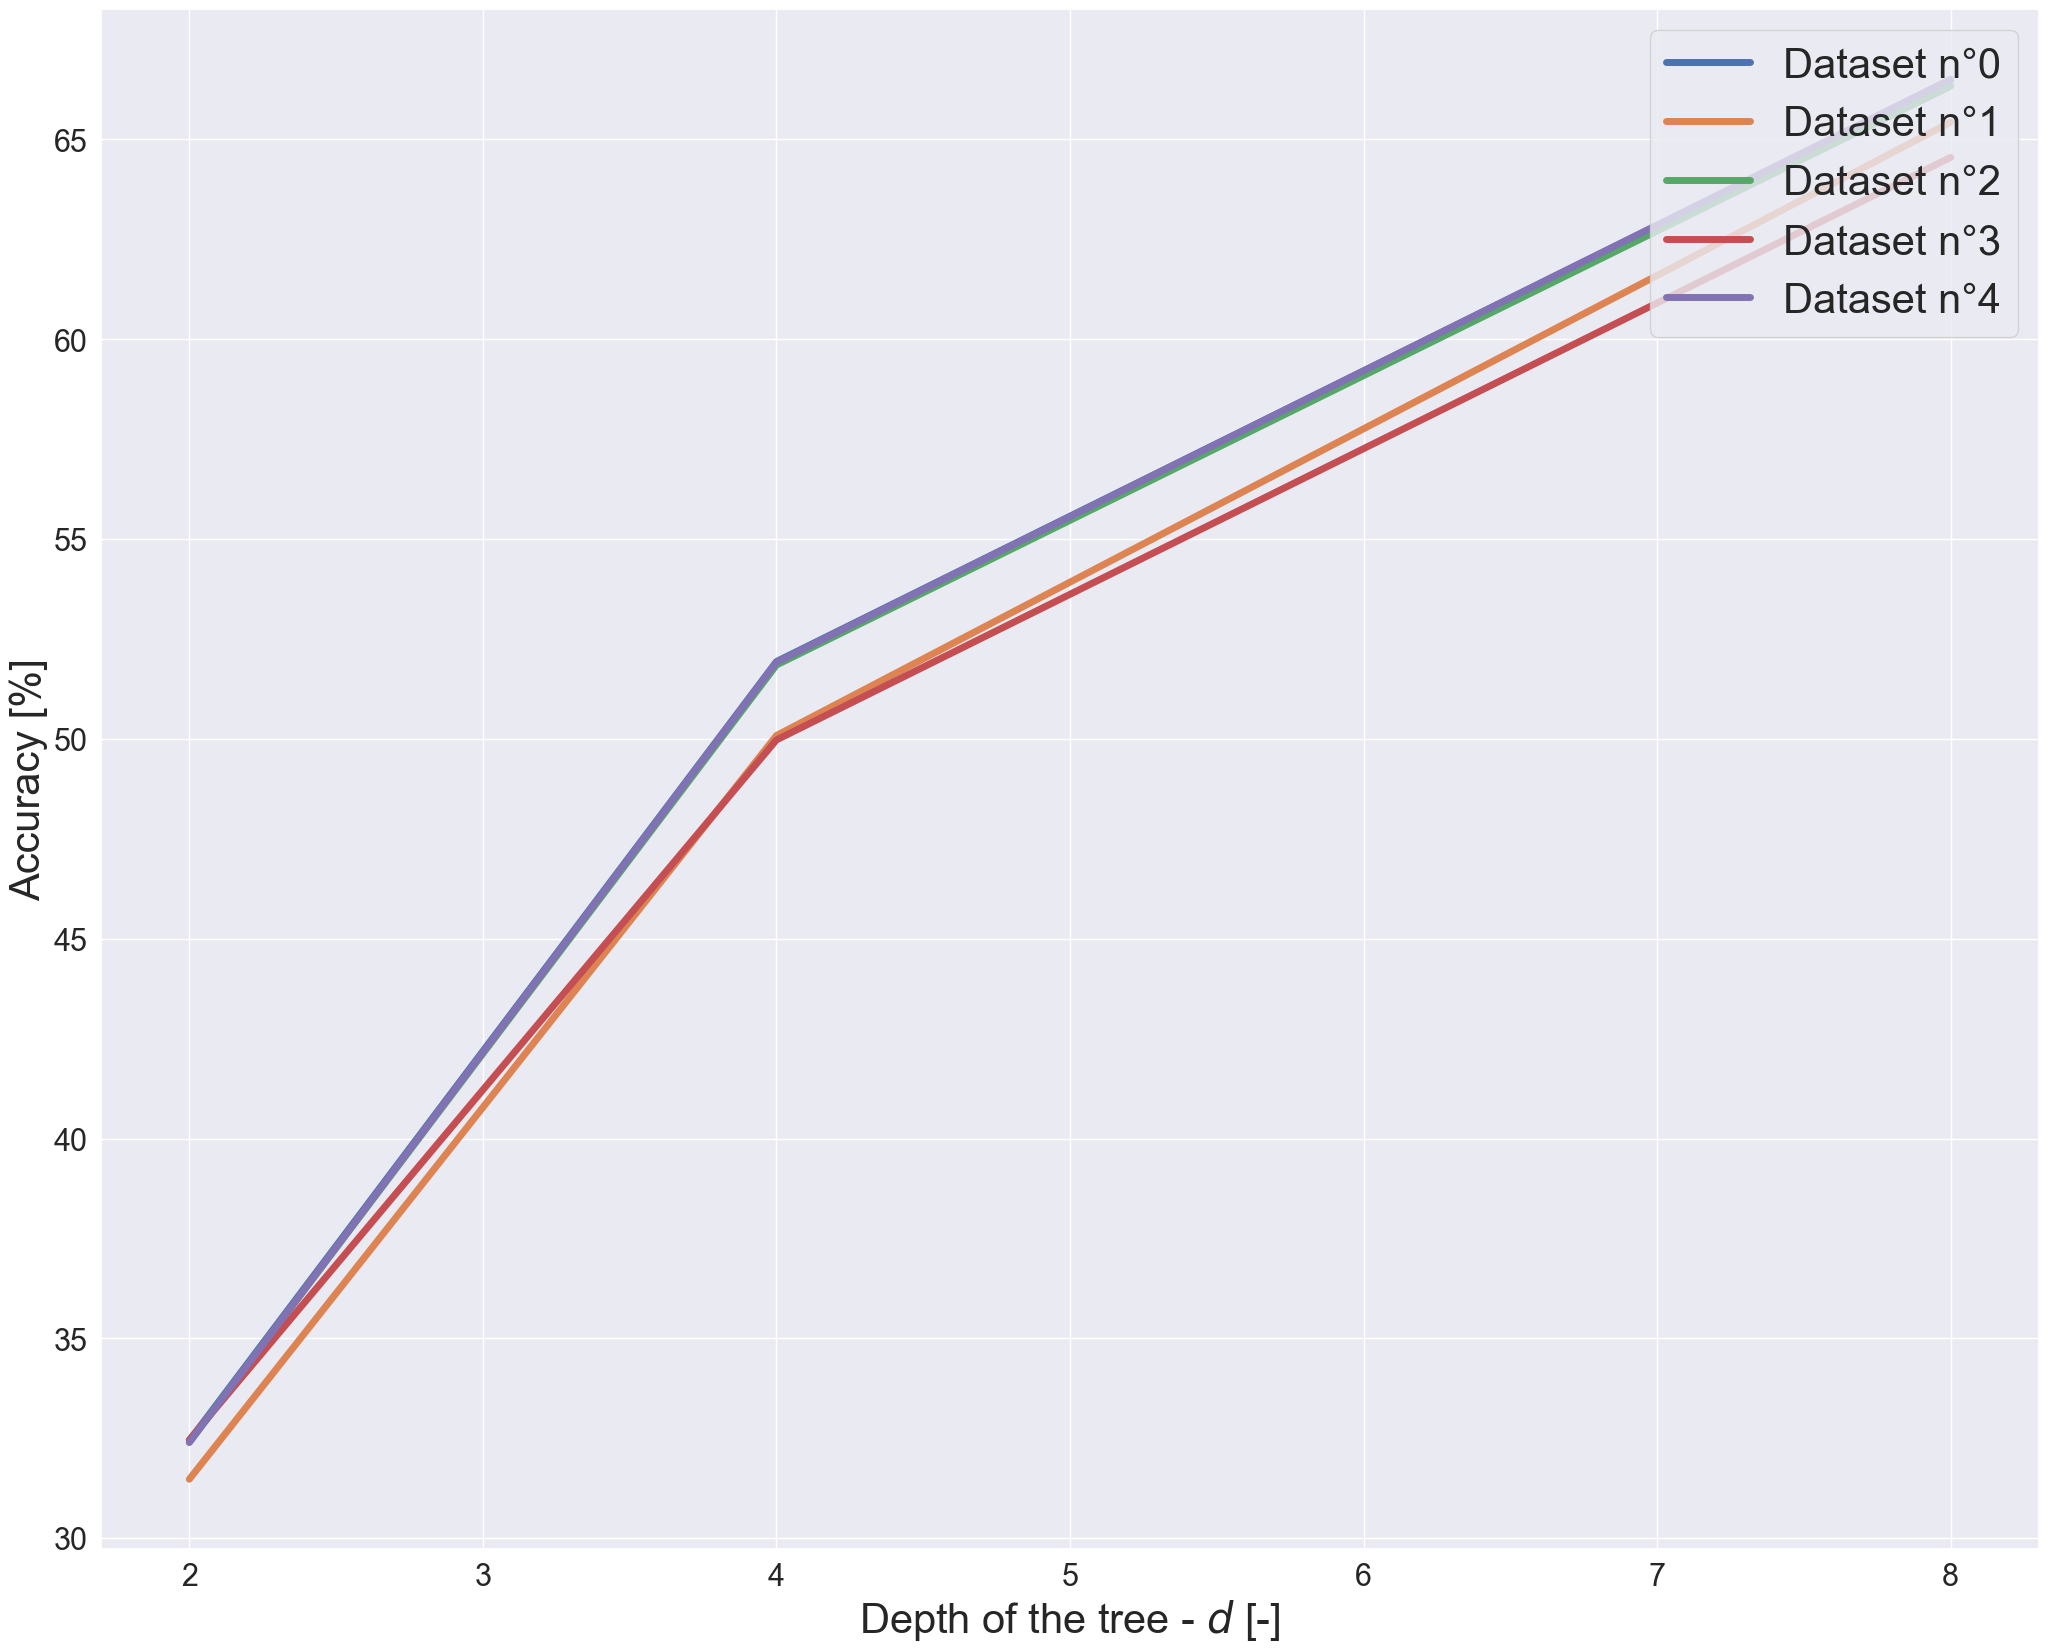

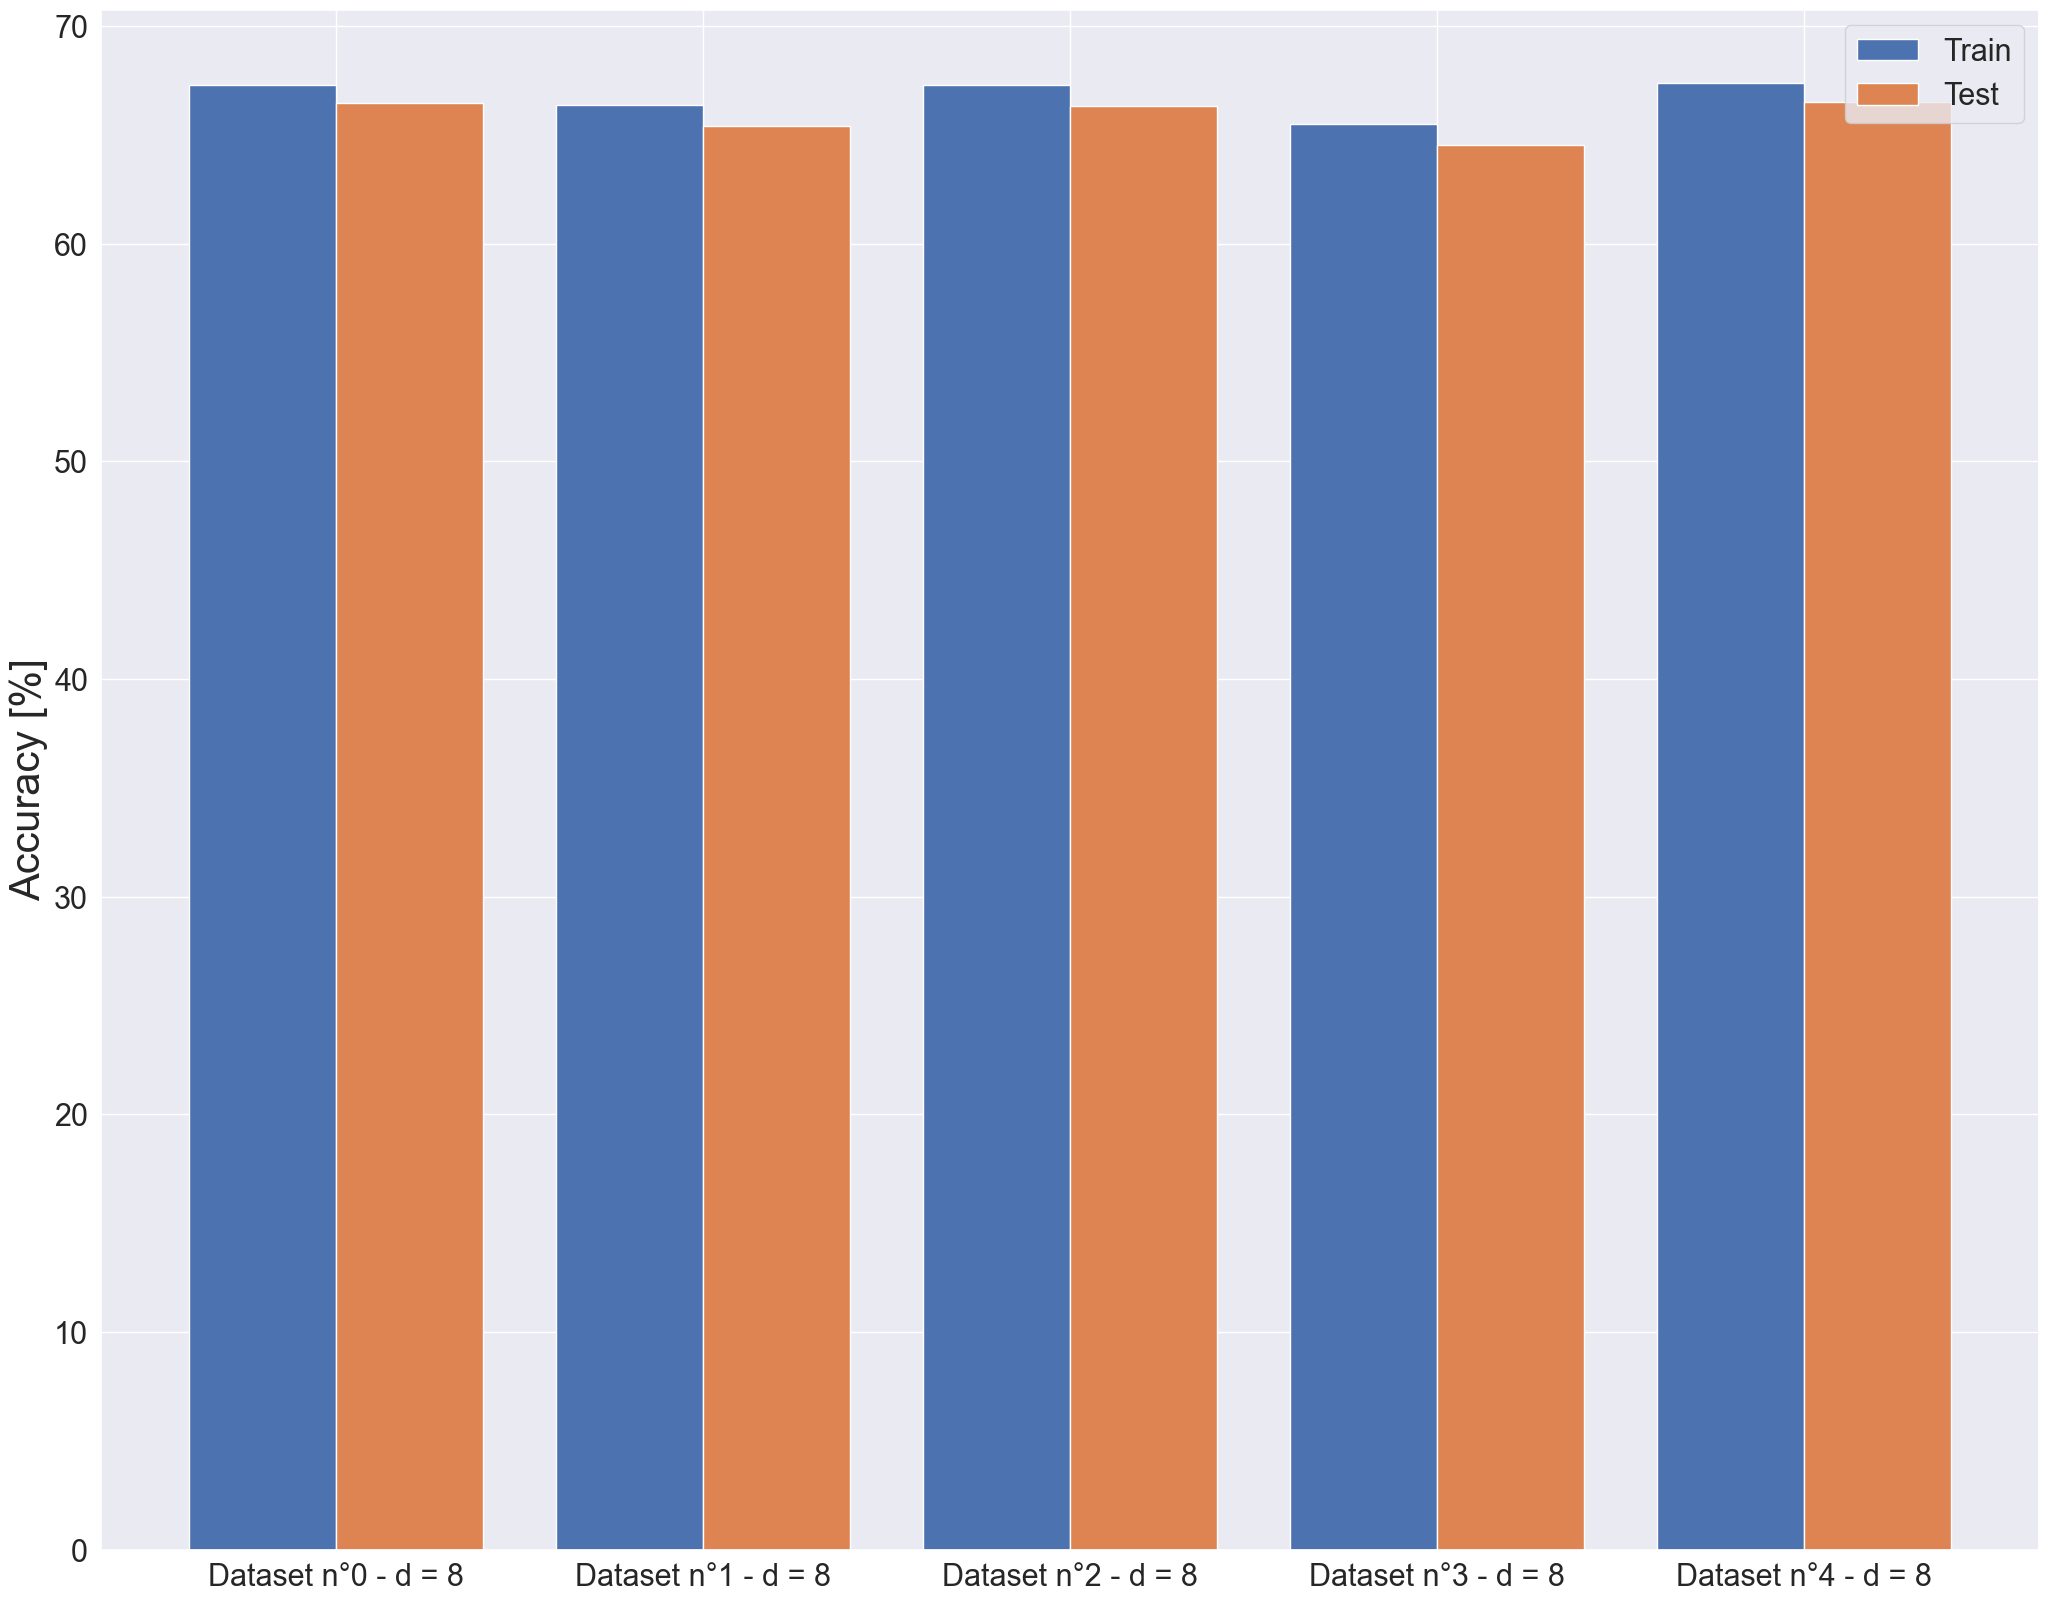

In [ ]:
# -- Deep Learning Librairies --
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
# -- Neural Network (MLP) -- 
class MLP_PowerPrediction(nn.Module):

    # Initalization of the model
    def __init__(self, input_size, output_size = 1, device = "None"):

        # Need to call the super to define child functions
        super(MLP_PowerPrediction, self).__init__()

        # Defining the fully connected layers
        self.fc1 = nn.Linear(input_size, 32, dtype = "float64")
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, output_size)

    # Defining how data will flow through the network
    def forward(self, x):

        # The Network is quite simple (A chain of fully connected and ReLu activation functions)
        #
        # First Layer
        x = self.fc1(x)
        x = F.relu(x)

        # Second Layer
        x = self.fc2(x)
        x = F.relu(x)

        # Third Layer
        x = self.fc3(x)
        x = F.relu(x)

        # Fourth Layer
        return self.fc4(x)

In [ ]:
# -- Dataloader & Dataset (For the training of neural networks, one need batch of inputs) --
class PowerDataset(Dataset):
  def __init__(self, x, y):
      self.x = x
      self.y = y
      
  def __getitem__(self, index):
      return (self.x[index], self.y[index])
  
  def __len__(self):
      return self.x.shape[0]

# Loading a dataset into a readable shape
POWER_dataset  = DataLoader(PowerDataset(data_X0, data_Y0), batch_size = 64)

In [ ]:
# -- Setting up -- 
#
# Dataset 
POWER_data_X   = data_X0.to_numpy()
POWER_data_Y   = data_Y0.to_numpy()
POWER_dataset  = DataLoader(PowerDataset(POWER_data_X, POWER_data_Y), batch_size = 64)

# Intialization of the network
model = MLP_PowerPrediction(len(POWER_data_X[0]))

In [ ]:
# -- Parameters
num_epochs = 2
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs * 3/4), int(num_epochs * 7/8)], gamma=0.1)
criterion = nn.MSELoss()


In [ ]:
# Start training
for epoch in range(num_epochs):

    # Display useful information over terminal (1)
    print("Epoch : ", epoch + 1, "/", num_epochs)

    # Retreiving a batch of data
    for x, y in POWER_dataset:

        # Reseting gradients
        optimizer.zero_grad()

        # Computing prediction and storing target
        yhat  = model.forward(x)
        ytrue = y

        # Computing loss
        loss = criterion(yhat, ytrue)
        loss.backward()

        # Optimization
        optimizer.step()

        # Updating epoch info ! Would be nice to upgrade it !
        print(loss.item())


    # Updating timing
    # Just to make sure there is no overlap between progress bar and section
    print(" ")

    # Updating the scheduler to update learning rate !
    scheduler.step()

<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Quelqu'un de chaud bouillant
    </b>
</p>

<hr style="color:#c6cde1; width: 220px;" align="left">
<p style="color:#c6cde1;">Ensemble (Pre-Classifier with RF)</p>
<hr style="color:#c6cde1; width: 220px;" align="left">